# Recommender Systems 2022/23

### Practice 3 - Content Based recommenders


### Load the data you saw last time:

In [1]:
from urllib.request import urlretrieve
import zipfile, os

# If file exists, skip the download
data_file_path = "Data_manager_split_datasets/Movielens10M/"
data_file_name = data_file_path + "movielens_10m.zip"

# If directory does not exist, create
if not os.path.exists(data_file_path):
    os.makedirs(data_file_path)

if not os.path.exists(data_file_name):
    urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", data_file_name)
    
dataFile = zipfile.ZipFile(data_file_path + "movielens_10m.zip")

URM_path = dataFile.extract("ml-10M100K/ratings.dat", path = data_file_path + "decompressed/")

URM_file = open(URM_path, 'r')

In [2]:
import pandas as pd

URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep="::", 
                                header=None, 
                                dtype={0:int, 1:int, 2:float, 3:int},
                                engine='python')

URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction", "Timestamp"]

In [3]:
URM_all_dataframe.head(n=10)

,UserID,ItemID,Interaction,Timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392
5,1,329,5.0,838983392
6,1,355,5.0,838984474
7,1,356,5.0,838983653
8,1,362,5.0,838984885
9,1,364,5.0,838983707


## And now load the content informations in the same way:
## In this case we are using tags. The ICM also contains the user that added the tag in column 0 (but we don't use that information).

In [4]:
ICM_path = dataFile.extract("ml-10M100K/tags.dat", path = data_file_path + "decompressed/")

ICM_dataframe = pd.read_csv(filepath_or_buffer=ICM_path, 
                            sep="::", 
                            header=None, 
                            dtype={0:int, 1:int, 2:str, 3:int},
                            engine='python')

ICM_dataframe.columns = ["UserID", "ItemID", "FeatureID", "Timestamp"]

# Some nan values exist, remove them
ICM_dataframe = ICM_dataframe[ICM_dataframe["FeatureID"].notna()]

In [5]:
ICM_dataframe.head(n=10)

,UserID,ItemID,FeatureID,Timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867
3,20,2424,chick flick 212,1188263835
4,20,2424,hanks,1188263835
5,20,2424,ryan,1188263835
6,20,2947,action,1188263755
7,20,2947,bond,1188263756
8,20,3033,spoof,1188263880
9,20,3033,star wars,1188263880


### We can see that most users and items have no data associated to them

In [6]:
n_features = len(ICM_dataframe["FeatureID"].unique())

print ("Number of tags\t {}, Number of item-tag tuples {}".format(n_features, len(ICM_dataframe)))

Number of tags	 16528, Number of item-tag tuples 95564


## We now build the sparse URM and ICM matrices

### The tags are strings, we should traslate them into numbers so we can use them as indices in the ICM.
### We should also ensure that the item and user indices we use in ICM and URM are consistent. To do so we use the same mapper, first we populate it with the URM and then we add the new ids that appear only in the ICM

In [7]:
mapped_id, original_id = pd.factorize(URM_all_dataframe["UserID"].unique())

print("Unique UserID in the URM are {}".format(len(original_id)))

all_item_indices = pd.concat([URM_all_dataframe["UserID"], ICM_dataframe["UserID"]], ignore_index=True)
mapped_id, original_id = pd.factorize(all_item_indices.unique())

print("Unique UserID in the URM and ICM are {}".format(len(original_id)))

user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

Unique UserID in the URM are 69878
Unique UserID in the URM and ICM are 71567


In [8]:
mapped_id, original_id = pd.factorize(URM_all_dataframe["ItemID"].unique())

print("Unique ItemID in the URM are {}".format(len(original_id)))

all_item_indices = pd.concat([URM_all_dataframe["ItemID"], ICM_dataframe["ItemID"]], ignore_index=True)
mapped_id, original_id = pd.factorize(all_item_indices.unique())

print("Unique ItemID in the URM and ICM are {}".format(len(original_id)))

item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

Unique ItemID in the URM are 10677
Unique ItemID in the URM and ICM are 10681


In [9]:
mapped_id, original_id = pd.factorize(ICM_dataframe["FeatureID"].unique())
feature_original_ID_to_index = pd.Series(mapped_id, index=original_id)

print("Unique FeatureID in the URM are {}".format(len(feature_original_ID_to_index)))

Unique FeatureID in the URM are 16528


In [10]:
original_feature_ID = "star wars"
print("New index for feature '{}' is {}".format(original_feature_ID, feature_original_ID_to_index[original_feature_ID]))

New index for feature 'star wars' is 9


# We can now build the URM and ICM using the new indices


In [11]:
URM_all_dataframe["UserID"] = URM_all_dataframe["UserID"].map(user_original_ID_to_index)
URM_all_dataframe["ItemID"] = URM_all_dataframe["ItemID"].map(item_original_ID_to_index)

In [12]:
URM_all_dataframe.head(n=10)

,UserID,ItemID,Interaction,Timestamp
0,0,0,5.0,838985046
1,0,1,5.0,838983525
2,0,2,5.0,838983392
3,0,3,5.0,838983421
4,0,4,5.0,838983392
5,0,5,5.0,838983392
6,0,6,5.0,838984474
7,0,7,5.0,838983653
8,0,8,5.0,838984885
9,0,9,5.0,838983707


In [13]:
ICM_dataframe["UserID"] = ICM_dataframe["UserID"].map(user_original_ID_to_index)
ICM_dataframe["ItemID"] = ICM_dataframe["ItemID"].map(item_original_ID_to_index)
ICM_dataframe["FeatureID"] = ICM_dataframe["FeatureID"].map(feature_original_ID_to_index)

In [14]:
ICM_dataframe.head(n=10)

,UserID,ItemID,FeatureID,Timestamp
0,69878,1926,0,1215184630
1,69879,1040,1,1188263867
2,69879,1040,2,1188263867
3,69879,1086,3,1188263835
4,69879,1086,4,1188263835
5,69879,1086,5,1188263835
6,69879,612,6,1188263755
7,69879,612,7,1188263756
8,69879,628,8,1188263880
9,69879,628,9,1188263880


### When we create the matrices we need to make sure they have the same shape. As we have seen some items and users only appear in one of the two matrices and are missing in the other (if they have no tags or no interactions)

In [15]:
import scipy.sparse as sps
import numpy as np

n_users = len(user_original_ID_to_index)
n_items = len(item_original_ID_to_index)
n_features = len(feature_original_ID_to_index)

In [16]:
URM_all = sps.csr_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)),
                        shape = (n_users, n_items))

URM_all

<71567x10681 sparse matrix of type '<class 'numpy.float64'>'
	with 10000054 stored elements in Compressed Sparse Row format>

In [17]:
ICM_all = sps.csr_matrix((np.ones(len(ICM_dataframe["ItemID"].values)), 
                          (ICM_dataframe["ItemID"].values, ICM_dataframe["FeatureID"].values)),
                        shape = (n_items, n_features))

ICM_all.data = np.ones_like(ICM_all.data)

ICM_all

<10681x16528 sparse matrix of type '<class 'numpy.float64'>'
	with 71140 stored elements in Compressed Sparse Row format>

# Let's take a look at the ICM

### We leverage CSR and CSC indptr data structure to compute the number of cells that have values for that row or column

In [18]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [19]:
print(features_per_item.shape)
print(items_per_feature.shape)

(10681,)
(16528,)


In [20]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

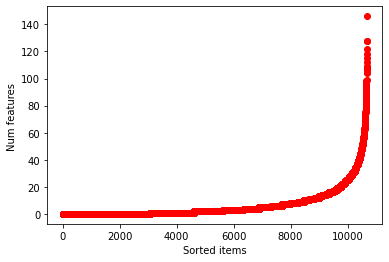

In [21]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Sorted items')
pyplot.show()

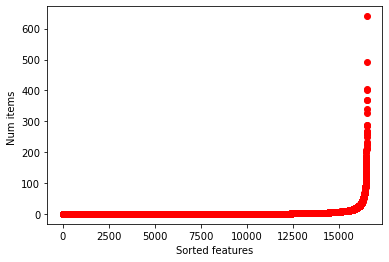

In [22]:
pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Sorted features')
pyplot.show()

# We can now build the recommender algorithm, but first we need the train/test split and the evaluation function:

In [23]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 1935 ( 2.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 1759 ( 2.5%) Users that have less than 1 test interactions


### We need to define Cosine similarity... Let's look at the attached source code

### See also a [list of commonly used KNN similarity heuristics](https://github.com/MaurizioFD/RecSys_Course_2018/blob/master/slides/List_of_KNN_similarity_heuristics.pdf)

## A KNN is built with the following steps:
* Compute the similarity of an item with all others
* Select the k-highest similarities

In [24]:
item_id = 80
shrink = 10

The numerator is the dot product of the item features times the whole ICM data transposed

In [25]:
numerator_vector = ICM_all[item_id].dot(ICM_all.T).toarray().ravel()
numerator_vector

array([2., 0., 0., ..., 0., 1., 0.])

In [26]:
item_norms = np.sqrt(np.array(ICM_all.T.power(2).sum(axis=0))).ravel()
item_norms

array([1.73205081, 4.35889894, 5.29150262, ..., 1.        , 1.41421356,
       1.41421356])

The denominator will be the product of norms plus the srink term and a small value which prevents the denominator to be zero (only for non-negative data)

In [27]:
denominator_vector = item_norms[item_id] * item_norms + shrink + 1e-6
denominator_vector

array([15.47722658, 23.78404975, 26.73320153, ..., 13.16227866,
       14.47213695, 14.47213695])

In [28]:
similarity_vector = numerator_vector/denominator_vector

Let's sort the similarity from the highest to the lowest

In [29]:
sorted_item_indices = np.argsort(-similarity_vector)
sorted_item_indices

array([   80,  3542,     0, ...,  3938,  3931, 10680], dtype=int64)

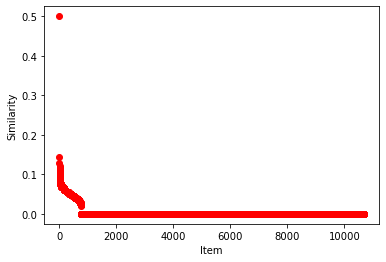

In [30]:
pyplot.plot(similarity_vector[sorted_item_indices], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

Now we select the k most similar items

In [31]:
k = 100

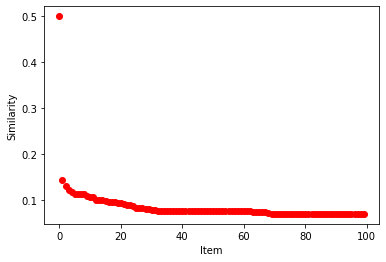

In [32]:
pyplot.plot(similarity_vector[sorted_item_indices[0:k]], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

The operation is performed for all items.
A simple strategy to perform it efficiently is to vectorize the most computationally intensive part, the dot product, on a group of items. The speedup can be of a factor of 10-100.
This strategy is limited by the fact that the result of the dot product is a huge item-item dense similarity which likely does not fit in memory.

In [33]:
import traceback

try:
    numerator_matrix = ICM_all.dot(ICM_all.T).toarray()
    
except Exception as e:
    traceback.print_exc()
    

The solution is:
* Compute the numerator a block of items at a time leveraging vectorization while not running out of memory
* Extract the k-nn on those items
* Built incrementally the sparse similarity matrix

In [34]:
block_size = 100

numerator_block = ICM_all[0:block_size].dot(ICM_all.T).toarray()
numerator_block.shape

(100, 10681)

Let's compare the speed to compute the dot product on the whole similarity of the two strategies

In [35]:
import time

n_items = ICM_all.shape[0]

start_time = time.time()

for n_item in range(n_items):
    numerator_vector = ICM_all[item_id].dot(ICM_all.T).toarray().ravel()
    
end_time = time.time()

print("Computing the similarity one item at a time runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))

Computing the similarity one item at a time runs at 985.58 items/sec


In [36]:
n_items = ICM_all.shape[0]

start_time = time.time()

block_size = 100
blocks_start_positions = range(0, n_items, block_size)

for start_pos in blocks_start_positions:
    end_pos = min(start_pos + block_size, n_items)
    
    numerator_block = ICM_all[start_pos:end_pos].dot(ICM_all.T).toarray()
    
end_time = time.time()

print("Computing the similarity in blocks of 100 items at a time runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))

Computing the similarity in blocks of 100 items at a time runs at 27339.09 items/sec


### In this case the vectorized implementation runs >20 times faster!

#### Usually most of the speed gain comes with blocks of 100 or so items, depending on the system. Much higher than that tends to not be beneficial while requiring increasingly more memory.

Now an example of something you should *never* do, nested loops to compute the similarity of each item without vectorization

In [37]:
n_items = 100

start_time = time.time()

for n_item in range(n_items):
    for second_item in range(n_items):
        numerator_vector = ICM_all[item_id].dot(ICM_all[second_item].T)
    
end_time = time.time()

print("Computing the similarity with nested loops runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))

Computing the similarity with nested loops runs at 27.57 items/sec


You see how incredibly slow nested loops are compared to a well vectorized implementation

#### Let's now compute the entire similarity matrix and use it to generate recommendations

In [38]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(ICM_all.T, shrink=0.0, 
                                          topK=100,
                                          normalize=True, 
                                          similarity = "cosine")

W_sparse = similarity_object.compute_similarity()
W_sparse

Similarity column 10681 (100.0%), 3044.67 column/sec. Elapsed time 3.51 sec


<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 624041 stored elements in Compressed Sparse Row format>

In [39]:
user_id = 200
user_profile = URM_train[user_id]

scores = user_profile.dot(W_sparse)
scores

<1x10681 sparse matrix of type '<class 'numpy.float64'>'
	with 5309 stored elements in Compressed Sparse Row format>

In [40]:
scores = scores.toarray().ravel()
scores

array([0.        , 5.06626014, 4.63941215, ..., 0.        , 0.        ,
       0.        ])

We can then sort the scores to recommend the highest ranked ones

In [41]:
ranking = scores.argsort()[::-1][0:10]
ranking

array([ 436, 2643, 7714, 3082, 6302,  235,   37, 6586, 6183,  179],
      dtype=int64)

In [42]:
scores[ranking]

array([23.67845091, 20.97654562, 20.79778096, 20.79778096, 20.13316749,
       20.01614007, 19.26797123, 19.07612655, 18.62343012, 17.8655453 ])

## Test our CBF recommender:

#### We put everything in a Python class with a standard interface

In [43]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

class ItemKNNCBFRecommender(object):
    
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
        
            
    def fit(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object = Compute_Similarity_Python(self.ICM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

In [44]:
recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 10681 (100.0%), 3424.33 column/sec. Elapsed time 3.12 sec


In [45]:
for user_id in range(10):
    print(recommender.recommend(user_id, at=5))

[ 284   94 5512 1451 2008]
[ 177  196 1234  822  554]
[5138 9277 5018   60  798]
[1723  441 5106  425 3117]
[ 176    7  403 1184 1314]
[  37  822   19  798 1234]
[ 220  218  144  219 1139]
[2366 2333 3736 2340 1102]
[1073 4584 1994 4390  170]
[1310   34   16 1314  402]


#### Let's talk about speed

#### Time to compute recommendations for a fixed group of users

In [46]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

Reasonable implementation speed is 703.86 usr/sec


### Let's add a common mistake.... a CSC URM

In [47]:
URM_train_csc = URM_train.tocsc()

recommender = ItemKNNCBFRecommender(URM_train_csc, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 10681 (100.0%), 3635.56 column/sec. Elapsed time 2.94 sec


In [48]:
import time, traceback

try:

    n_users_to_test = 1000

    start_time = time.time()

    for user_id in range(n_users_to_test):
        recommender.recommend(user_id, at=5)

    end_time = time.time()

    print("Wrong implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

    
except Exception as e:
        
    print("Exception {}".format(str(e)))
    traceback.print_exc()

Exception index 10683 is out of bounds for axis 0 with size 10681


Traceback (most recent call last):
  File "C:\Users\ferra\AppData\Local\Temp/ipykernel_10832/1155062715.py", line 10, in <module>
    recommender.recommend(user_id, at=5)
  File "C:\Users\ferra\AppData\Local\Temp/ipykernel_10832/4145966258.py", line 25, in recommend
    scores = self.filter_seen(user_id, scores)
  File "C:\Users\ferra\AppData\Local\Temp/ipykernel_10832/4145966258.py", line 40, in filter_seen
    scores[user_profile] = -np.inf
IndexError: index 10683 is out of bounds for axis 0 with size 10681


## Hyperparameter tuning

#### Once we have built our model we can play with its hyperparameters
* Number of neighbors
* Shrinkage
* Similarity type


Do not confuse "hyperparameter" with "parameter". A hyperparameter is someting that influences the model structure (number of neighbors, similarity type) or its training phase (learning rate, regularization), while the parameters are the model components (for example the actual value of the similarity between two items) whose values are learned with machine learning.

### Number of neighbors

#### First let's use Grid Search. To do that we need to specify a list of values to test. Grid search is simple to implement but is largely obsolete, it is widely known that it is very inefficient and difficult to set up correctly (which values do you choose?). It is strongly discouraged.

In [49]:
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

x_tick_grid = [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
MAP_per_k_grid = []

for topK in x_tick_grid:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_k_grid.append(result_df.loc[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 13547.62 column/sec. Elapsed time 0.79 sec
EvaluatorHoldout: Processed 69808 (100.0%) in 42.29 sec. Users per second: 1651
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 12689.76 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 69808 (100.0%) in 50.34 sec. Users per second: 1387
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity 

### Even better, use a random search!

#### Just use a random number generator to select the values you want. It is more efficient than greed search and just as simple to implement. It is important to decide if we want to sample with a random distribution or a log-uniform distribution. Use a log-uniform if you need to sample both high and low values, for example you want to sample with uniform probability 10, 20 but also 100 and 200.

In [50]:
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from scipy.stats import loguniform

x_tick_rnd = loguniform.rvs(10, 500, size=11).astype(int)
x_tick_rnd.sort()
x_tick_rnd = list(x_tick_rnd)

MAP_per_k_rnd = []

for topK in x_tick_rnd:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_k_rnd.append(result_df.loc[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 13533.85 column/sec. Elapsed time 0.79 sec
EvaluatorHoldout: Processed 69808 (100.0%) in 44.10 sec. Users per second: 1583
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 14142.66 column/sec. Elapsed time 0.76 sec
EvaluatorHoldout: Processed 69808 (100.0%) in 43.93 sec. Users per second: 1589
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity 

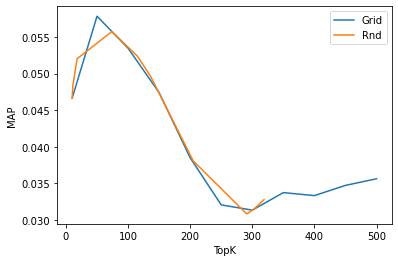

In [51]:
pyplot.plot(x_tick_grid, MAP_per_k_grid, label="Grid")
pyplot.plot(x_tick_rnd, MAP_per_k_rnd, label="Rnd")
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.legend()
pyplot.show()

#### On this dataset the number of neighbors has a small absolute impact on MAP but a large relative one. Fine-tuning around the best values is needed.

#### Different datasets will behave in different ways.

### Shrinkage

In [52]:
x_tick_grid = [0, 10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
MAP_per_shrinkage_grid = []

for shrink in x_tick_grid:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=shrink, topK=100)
    
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_shrinkage_grid.append(result_df.loc[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 14274.95 column/sec. Elapsed time 0.75 sec
EvaluatorHoldout: Processed 69808 (100.0%) in 47.71 sec. Users per second: 1463
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 13199.68 column/sec. Elapsed time 0.81 sec
EvaluatorHoldout: Processed 69808 (100.0%) in 51.87 sec. Users per second: 1346
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity 

In [53]:
x_tick_rnd = loguniform.rvs(0.1, 500, size=12).astype(int)
x_tick_rnd.sort()
x_tick_rnd = list(x_tick_rnd)

MAP_per_shrinkage_rnd = []

for shrink in x_tick_rnd:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=shrink, topK=100)
    
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_shrinkage_rnd.append(result_df.loc[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 14068.75 column/sec. Elapsed time 0.76 sec
EvaluatorHoldout: Processed 69808 (100.0%) in 47.45 sec. Users per second: 1471
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 14180.37 column/sec. Elapsed time 0.75 sec
EvaluatorHoldout: Processed 69808 (100.0%) in 48.09 sec. Users per second: 1452
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity 

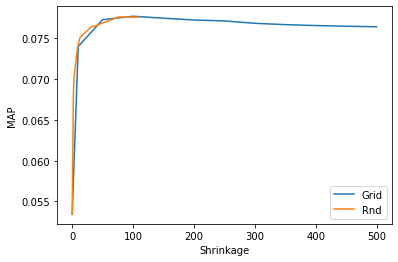

In [54]:
pyplot.plot(x_tick_grid, MAP_per_shrinkage_grid, label="Grid")
pyplot.plot(x_tick_rnd, MAP_per_shrinkage_rnd, label="Rnd")
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.legend()
pyplot.show()

#### The shrinkage value (i.e. support) have a much stronger impact. Combine a hyperparameter search with the two to ensure maximum recommendation quality

## Be careful, overfitting!

#### While a thorough parameter tuning might result in significantly higher MAP on your validation split, it could have only marginally better or even worse MAP on the test set

# Feature weighting

# IDF

![title](https://www.link-assistant.com/images/news/tf-idf-tool-for-seo/screen-03.png)

In [55]:
num_tot_items = ICM_all.shape[0]

# let's count how many items have a certain feature
items_per_feature = np.ediff1d(sps.csc_matrix(ICM_all).indptr)

IDF = np.log(num_tot_items / items_per_feature)

print(ICM_all.shape)
print(IDF.shape)

(10681, 16528)
(16528,)


In [56]:
np.sort(items_per_feature)

array([  1,   1,   1, ..., 404, 492, 640], dtype=int32)

In [57]:
np.sort(IDF)

array([2.81475356, 3.07774302, 3.27480686, ..., 9.27622174, 9.27622174,
       9.27622174])

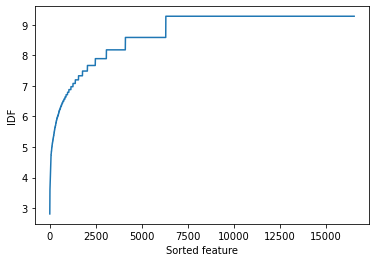

In [58]:
pyplot.plot(np.sort(IDF))
pyplot.ylabel('IDF')
pyplot.xlabel('Sorted feature')
pyplot.show()

#### Highest ranked features

In [59]:
feature_index_to_original_ID_dict = {value:key for key,value in feature_original_ID_to_index.iteritems()}

In [60]:
sorted_features = np.argsort(-IDF)

highest_ranked_features = sorted_features[:20]

for feature_index in highest_ranked_features:
    print(feature_index_to_original_ID_dict[feature_index])

a old story of fight
i hate this movie with a fiery passion
so damn good
cool-ish
i love this movie
ukraine
don't watch it again
NOT Eugene O'Neill - S. Africa
why do i hate this?
Yakuza Papers I
needless gratuitous violence
always applicable to present
insanely funny
homoerotic hobbit-on-hobbit action
musical score drives me crazy!
brilliant in concept & execution
modern male friendship
almost favourite
this movie is pretty...pretty gay
instant classic


#### Lowest ranked features

In [61]:
lowest_ranked_features = sorted_features[-20:]

for feature_index in lowest_ranked_features:
    print(feature_index_to_original_ID_dict[feature_index])    

atmospheric
library
seen more than once
Nudity (Topless - Brief)
To See
adapted from:book
imdb top 250
Can't remember
classic
Bibliothek
National Film Registry
Betamax
movie to see
Nudity (Topless)
based on a book
70mm
R
erlend's DVDs
less than 300 ratings
Tumey's DVDs


In [62]:
from scipy.sparse import diags
diags(IDF)

<16528x16528 sparse matrix of type '<class 'numpy.float64'>'
	with 16528 stored elements (1 diagonals) in DIAgonal format>

In [63]:
ICM_idf = ICM_all.copy()

ICM_idf = ICM_idf*diags(IDF)

In [64]:
recommender_idf = ItemKNNCBFRecommender(URM_train, ICM_idf)
recommender_idf.fit(shrink=0.0, topK=50)

result_df, _ = evaluator_test.evaluateRecommender(recommender_idf)
result_df.loc[10]

ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 14370.85 column/sec. Elapsed time 0.74 sec
EvaluatorHoldout: Processed 69808 (100.0%) in 43.80 sec. Users per second: 1594


PRECISION                     0.064261
PRECISION_RECALL_MIN_DEN      0.069066
RECALL                        0.031154
MAP                           0.032879
MAP_MIN_DEN                   0.035015
MRR                           0.180819
NDCG                          0.061338
F1                            0.041963
HIT_RATE                      0.358827
ARHR_ALL_HITS                 0.240779
NOVELTY                        0.01286
AVERAGE_POPULARITY            0.145106
DIVERSITY_MEAN_INTER_LIST     0.974796
DIVERSITY_HERFINDAHL          0.997478
COVERAGE_ITEM                 0.496208
COVERAGE_ITEM_HIT             0.118996
ITEMS_IN_GT                   0.960865
COVERAGE_USER                 0.975422
COVERAGE_USER_HIT             0.350008
USERS_IN_GT                   0.975422
DIVERSITY_GINI                0.084978
SHANNON_ENTROPY               9.970774
RATIO_DIVERSITY_HERFINDAHL    0.998231
RATIO_DIVERSITY_GINI          0.436642
RATIO_SHANNON_ENTROPY         0.880465
RATIO_AVERAGE_POPULARITY 

#### Try other feature weighting methods like BM25...

# BM25

In [65]:
from Recommenders.IR_feature_weighting import okapi_BM_25

ICM_BM25 = ICM_all.copy().astype(np.float32)
ICM_BM25 = okapi_BM_25(ICM_BM25)
ICM_BM25 = ICM_BM25.tocsr()

In [66]:
recommender_bm25 = ItemKNNCBFRecommender(URM_train, ICM_BM25)
recommender_bm25.fit(shrink=0.0, topK=50)

result_df, _ = evaluator_test.evaluateRecommender(recommender_bm25)
result_df.loc[10]

ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 14546.71 column/sec. Elapsed time 0.73 sec
EvaluatorHoldout: Processed 69808 (100.0%) in 44.04 sec. Users per second: 1585


PRECISION                     0.068012
PRECISION_RECALL_MIN_DEN      0.073047
RECALL                        0.032823
MAP                           0.034988
MAP_MIN_DEN                   0.037264
MRR                           0.189115
NDCG                          0.064866
F1                            0.044277
HIT_RATE                      0.373439
ARHR_ALL_HITS                 0.253897
NOVELTY                       0.012732
AVERAGE_POPULARITY            0.156445
DIVERSITY_MEAN_INTER_LIST     0.973196
DIVERSITY_HERFINDAHL          0.997318
COVERAGE_ITEM                 0.498268
COVERAGE_ITEM_HIT             0.118809
ITEMS_IN_GT                   0.960865
COVERAGE_USER                 0.975422
COVERAGE_USER_HIT              0.36426
USERS_IN_GT                   0.975422
DIVERSITY_GINI                0.083546
SHANNON_ENTROPY               9.922846
RATIO_DIVERSITY_HERFINDAHL    0.998071
RATIO_DIVERSITY_GINI          0.429285
RATIO_SHANNON_ENTROPY         0.876233
RATIO_AVERAGE_POPULARITY 

#### A small gain over TF-IDF

# Unnormalized similarity matrix

In [67]:
recommender_dot = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender_dot.W_sparse = ICM_all * ICM_all.T

result_df, _ = evaluator_test.evaluateRecommender(recommender_dot)
result_df.loc[10]

ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
EvaluatorHoldout: Processed 69808 (100.0%) in 1.15 min. Users per second: 1008


PRECISION                     0.123222
PRECISION_RECALL_MIN_DEN      0.133744
RECALL                        0.059976
MAP                           0.067868
MAP_MIN_DEN                    0.07275
MRR                            0.32608
NDCG                          0.129453
F1                            0.080682
HIT_RATE                      0.586552
ARHR_ALL_HITS                 0.460047
NOVELTY                       0.008519
AVERAGE_POPULARITY            0.580033
DIVERSITY_MEAN_INTER_LIST     0.599504
DIVERSITY_HERFINDAHL           0.95995
COVERAGE_ITEM                 0.048965
COVERAGE_ITEM_HIT             0.018257
ITEMS_IN_GT                   0.960865
COVERAGE_USER                 0.975422
COVERAGE_USER_HIT             0.572135
USERS_IN_GT                   0.975422
DIVERSITY_GINI                0.002441
SHANNON_ENTROPY               5.047136
RATIO_DIVERSITY_HERFINDAHL    0.960674
RATIO_DIVERSITY_GINI          0.012541
RATIO_SHANNON_ENTROPY         0.445685
RATIO_AVERAGE_POPULARITY 